# Final Project: Energy Efficiency and Demand in Clean Energy Transitions (Part 2)

This notebook contains the final implementation of my data analysis project. I have built predictive models using both Machine Learning and Deep Learning approaches to forecast energy generation from renewable sources such as solar, wind, hydroelectric, and biofuel.

## Author

### *Carlos Vergara Gámez*
Github: https://github.com/PoeMadara

Linkedin: https://www.linkedin.com/in/carlosvergaragamez/

E-mail: carlos.poemadara@gmail.com

## Source

*The dataset utilized for this research was sourced from the following reference:*

> Ritchie, H., Rosado, P., & Roser, M. (2023). *Energy*. Published online at **OurWorldinData.org**. Retrieved from: [https://ourworldindata.org/energy](https://ourworldindata.org/energy) [Online Resource]

*This resource has been invaluable in providing comprehensive data for analyzing energy trends and facilitating informed insights in my research.*


## 1. Importing Libraries
I start by importing all the necessary libraries for data manipulation, visualization, and modeling.

In [1]:
# Importing necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from joblib import dump, load

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, SimpleRNN, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
# Create a folder called "final_models" if it doesn't exist
os.makedirs('final_models', exist_ok=True)

## 2. Loading the Cleaned Data
I previously cleaned the raw dataset and saved it as `cleaned_data_final.csv`. Here, I load that dataset and display the first few rows to confirm it's ready for analysis.

In [6]:
# Loading the cleaned data
df = pd.read_csv('data/clean/cleaned_data_final.csv')

# Displaying a random sample of 5 rows from the dataset
df.sample(5)

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
15569,Panama,1990,PAN,2449966.0,1.703577e+10,0.000,0.00,0.000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.0
5233,Cyprus,2021,CYP,1244193.0,3.242868e+10,-13.804,-0.04,199.518,0.248,48.224,...,9.180,0.0,2.525,0.014,0.645,200.933,0.25,518.371,4.883,0.0
12057,Middle Africa (EI),1971,0,0.0,0.000000e+00,0.000,0.00,0.000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.0
5565,Denmark,1953,DNK,4362493.0,5.078414e+10,0.000,0.00,0.000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.0
17417,Singapore,2021,SGP,5941063.0,4.455520e+11,0.000,0.00,0.000,0.000,205.350,...,0.717,0.0,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.0


## 3. Defining the Features and Target Variables
In this section, I define the features (independent variables) and the target variables (dependent variables). I will use these to train my machine learning models.

In [7]:
X = df[[
    'year', 'population', 'gdp', 'electricity_demand', 'electricity_generation',
    'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp',
    'solar_consumption', 'wind_consumption', 'biofuel_consumption'
]]

y = df[['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']]

## 4. Splitting the Data into Training and Testing Sets
I split the dataset into training (80%) and testing (20%) sets to evaluate model performance on unseen data.

In [8]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Training the Machine Learning Model: Random Forest and GridSearchCV
I will now train a Random Forest model using `MultiOutputRegressor` to predict multiple target variables. I also perform a grid search to find the best hyperparameters for the model.

In [9]:
# Initializing the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)  # Creates an instance with a fixed seed for reproducibility

# Wrapping it in a MultiOutputRegressor to handle multiple target variables
multi_rf = MultiOutputRegressor(rf)  # Allows predicting multiple targets simultaneously

# Defining the hyperparameters for grid search
param_grid = {
    'estimator__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'estimator__max_depth': [None, 10, 20],  # Maximum depth of each tree
    'estimator__min_samples_split': [2, 5, 10]  # Minimum samples required to split an internal node
}

# Performing grid search
grid_search = GridSearchCV(multi_rf, param_grid, cv=5, scoring='neg_mean_absolute_error')  # Executes grid search with 5-fold cross-validation
grid_search.fit(X_train, y_train)  # Fits the model to the training data

# Getting the best model from grid search
best_rf_model = grid_search.best_estimator_  # Retrieves the best-performing model

# Printing the best parameters
print("Best Parameters:", grid_search.best_params_)  # Displays optimal hyperparameters for the best model


Best Parameters: {'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}


In [10]:
# Saving the trained machine learning model
dump(best_rf_model, 'final_models/seap_ml_model.joblib')

['final_models/seap_ml_model.joblib']

## 6. Evaluating the Random Forest Model
Here, I evaluate the Random Forest model on the test set using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-Squared (R²) metrics.

In [11]:
# Making predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)  # Uses the best model to predict the target variable for the test dataset

# Calculating evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)  # Calculates Mean Absolute Error
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))  # Calculates Root Mean Squared Error
r2_rf = r2_score(y_test, y_pred_rf)  # Calculates R² score, indicating the proportion of variance explained by the model

# Printing evaluation metrics
print(f"MAE: {mae_rf:.4f}")  # Displays the MAE rounded to 4 decimal places
print(f"RMSE: {rmse_rf:.4f}")  # Displays the RMSE rounded to 4 decimal places
print(f"R²: {r2_rf:.4f}")  # Displays the R² score rounded to 4 decimal places


MAE: 1.7715
RMSE: 17.2922
R²: 0.9828


> The Random Forest model demonstrates strong performance:

- **MAE**: 1.7715 - Indicates a small average prediction error.
- **RMSE**: 17.2922 - Shows effective variability capture without significant outlier influence.
- **R²**: 0.9828 - Explains nearly 98.3% of the variance in the target variable.

Overall, these metrics highlight the model's robustness and reliability in predicting renewable energy generation.


### Cross-validation:


Cross-validation is used to assess the model's performance and ensure its generalizability by evaluating it on different subsets of the data.

In [12]:
# Perform cross-validation on the specified model using the provided data
scores = cross_val_score(best_rf_model, X, y, cv=5)  # X and y are your independent and dependent variables

# Output the individual cross-validated scores
print("Cross-validated scores:", scores)

# Calculate and print the mean score of the cross-validation scores to assess the model's overall performance
print("Mean score:", scores.mean())

Cross-validated scores: [0.8576651  0.82242854 0.91046173 0.86831421 0.94703239]
Mean score: 0.8811803931997633


The average cross-validated score of 0.8812 indicates strong model performance, suggesting it effectively generalizes to unseen data. The scores range from 0.8224 to 0.9470, showing some variability, which warrants further investigation to ensure consistency. Overall, **this is a solid result for predictive accuracy.**

## 7. Deep Learning Model Implementation
*In addition to Random Forest, I developed a deep learning model using Keras for multivariable energy generation prediction. Below is the implementation of the neural network.*

### Data Splitting

To begin from scratch with the deep learning model, I will use the same dataset that I previously utilized for the machine learning model. The data will be split into training and testing sets as follows:



In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Normalization

Before training the deep learning model, it is essential to normalize the data to improve convergence and performance. Normalization helps to scale the features to a similar range, which can enhance the model's ability to learn effectively. The normalization process is carried out as follows:


In [14]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Transform the test data without fitting


### Deep Learning Model Definition: Time Series Model for Multi-Variable Energy Generation Prediction

In this section, we define a deep learning model using Keras, which is structured as follows:

In [15]:
# Define the model
dl_model = Sequential()

# Input layer
dl_model.add(Input(shape=(X.shape[1],)))  # Ensure the shape matches the input features

# Adding hidden layers
dl_model.add(Dense(128, activation='relu', input_shape=(16,), kernel_regularizer=l2(0.01)))  # First hidden layer with L2 regularization
dl_model.add(Dense(64, activation='relu'))   # Second hidden layer
dl_model.add(Dense(32, activation='relu'))    # Third hidden layer
dl_model.add(Dense(16, activation='relu'))    # Fourth hidden layer

# Output layer for the 4 consumption variables
dl_model.add(Dense(4, activation='linear'))  # 4 neurons for multi-output regression

# Compile the model
dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Model Checkpoint Callback

To ensure that we save the best performing model during training, we utilize a callback mechanism provided by Keras. Below is the implementation of the checkpointing functionality:

In [16]:
# Callback to save the best model
checkpoint_path = 'final_models/seap_dp_times_series_model.keras'  # Path where the model will be saved
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_loss',  # Monitors the validation loss
    mode='min',          # Saves the model if the validation loss decreases
    verbose=1
)


### Early Stopping and Model Training

To prevent overfitting during the training of our deep learning model, we implement an Early Stopping mechanism. Below is the code for the Early Stopping callback and the model training process:

In [17]:
# Early Stopping to halt training if no improvement is observed
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the Deep Learning model
dl_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
             validation_data=(X_test_scaled, y_test), 
             callbacks=[model_checkpoint, early_stopping])


Epoch 1/100
531/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12137.8447
Epoch 1: val_loss improved from inf to 2519.09253, saving model to final_models/seap_deep_learning_model.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 11981.3281 - val_loss: 2519.0925
Epoch 2/100
508/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2595.0190
Epoch 2: val_loss improved from 2519.09253 to 2058.35669, saving model to final_models/seap_deep_learning_model.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2595.9685 - val_loss: 2058.3567
Epoch 3/100
514/546 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 2185.2051
Epoch 3: val_loss improved from 2058.35669 to 1934.64795, saving model to final_models/seap_deep_learning_model.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2194.5293 - val_loss: 1934.6479
Epoch 4/100
542/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1997.9791
Epoch 4: val_loss improved from 1934.64795 to 1813.01392, saving model to final_models/seap_deep_learning_model.keras
546/

## 8. Predictions and Evaluation of the Deep Learning Model

After training the deep learning model, we proceed to make predictions and evaluate its performance using several metrics. Below is the code for this process:

In [18]:
# Predictions with the Deep Learning model
dl_predictions = dl_model.predict(X_test_scaled)

# Evaluate the Deep Learning model
dl_mae = mean_absolute_error(y_test, dl_predictions)
dl_rmse = np.sqrt(mean_squared_error(y_test, dl_predictions))  # Changed to avoid warning
dl_r2 = r2_score(y_test, dl_predictions)

# Print results
print(f"DL Model - MAE: {dl_mae}, RMSE: {dl_rmse}, R²: {dl_r2}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DL Model - MAE: 5.119575843792624, RMSE: 24.485713030715917, R²: 0.913754940032959



The deep learning model achieved an MAE of 5.12 and an RMSE of 24.49, indicating some significant prediction errors. However, with an R² value of 0.91, it explains approximately 91% of the variance in the target variables, demonstrating strong predictive capability. Overall, the model performs well, but further refinement could help reduce larger discrepancies in predictions.


### Cross-Validation Implementation
The cross-validation process was set up using KFold with 5 splits, enabling the model to be trained and validated on different subsets of the training data. For each fold, a deep learning model was defined and trained, capturing the MAE, RMSE, and R² metrics for each validation set. This approach ensures a more robust evaluation of the model's performance by assessing its ability to generalize across different data distributions.

In [19]:
### Implementing Cross-Validation

# KFold Configuration
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for each fold
mae_list = []
rmse_list = []
r2_list = []

# Perform cross-validation
for train_index, val_index in kfold.split(X_train_scaled):
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train.values[train_index], y_train.values[val_index]

    # Define the model
    cv_model = Sequential()
    cv_model.add(Input(shape=(X.shape[1],)))
    cv_model.add(Dense(128, activation='relu'))
    cv_model.add(Dense(64, activation='relu'))
    cv_model.add(Dense(32, activation='relu'))
    cv_model.add(Dense(16, activation='relu'))
    cv_model.add(Dense(4, activation='linear'))

    # Compile the model
    cv_model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    cv_model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, 
                 validation_data=(X_val_cv, y_val_cv), 
                 verbose=0)  # Suppress training output for cleanliness

    # Predictions
    y_val_pred = cv_model.predict(X_val_cv)

    # Calculate metrics
    mae = mean_absolute_error(y_val_cv, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    r2 = r2_score(y_val_cv, y_val_pred)

    # Store metrics
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Print the average cross-validation metrics
print(f"Cross-Validation Results - MAE: {np.mean(mae_list)}, RMSE: {np.mean(rmse_list)}, R²: {np.mean(r2_list)}")


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Cross-Validation Results - MAE: 5.443674657109706, RMSE: 27.170737154910533, R²: 0.8677675557655835


### Results:
- **MAE:** 5.44
- **RMSE:** 27.17
- **R²:** 0.87

The neural network also shows good performance, but its training time was longer compared to Random Forest. The results indicate that deep learning could be a viable approach, though careful tuning of hyperparameters is required. 

Future adjustments to improve the model could include hyperparameter tuning, exploring different model architectures, and implementing regularization techniques. Additionally, more extensive testing with various datasets and cross-validation methods will be necessary to ensure robustness and generalization of the model.

---

### Recurrent Neural Network (RNN) for Renewable Energy Prediction

In [ ]:

# Step 1: Define features (X) and target (y)
X = df[[
    'year', 'population', 'gdp', 'electricity_demand', 'electricity_generation',
    'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp',
    'solar_consumption', 'wind_consumption', 'biofuel_consumption'
]]

y = df[['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']]

In [ ]:
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 3: Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Only transform the testing data

In [ ]:
# Step 4: Reshape the data for RNN input
# Reshape to [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))  # [samples, time steps, features]
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))  # [samples, time steps, features]

In [ ]:
# Step 5: Define the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))  # RNN layer
rnn_model.add(Dense(4, activation='linear'))  # Output layer for 4 target variables

In [ ]:
# Step 6: Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

### Model Checkpoint Callback

To ensure that we save the best performing model during training, we utilize a callback mechanism provided by Keras. Below is the implementation of the checkpointing functionality:

In [ ]:
# Step 7: Callback to save the best model
checkpoint_path = 'final_models/seap_dp_rnn_model.keras'  # Path where the model will be saved
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_loss',  # Monitors the validation loss
    mode='min',          # Saves the model if the validation loss decreases
    verbose=1
)

In [ ]:
# Step 8: Early Stopping to halt training if no improvement is observed

# Early Stopping to halt training if no improvement is observed
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the Deep Learning model
dl_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
             validation_data=(X_test_scaled, y_test), 
             callbacks=[model_checkpoint, early_stopping])


In [ ]:
# Step 9: Set up Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('seap_rnn_dp_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
# Step 10: Train the RNN model with validation split
history = rnn_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, 
                        validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

In [ ]:
# Step 11: Make predictions
rnn_predictions = rnn_model.predict(X_test_reshaped)

In [ ]:
# Step 12: Evaluate the model
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_predictions))
rnn_r2 = r2_score(y_test, rnn_predictions)

# Print evaluation metrics
print(f"RNN Model - MAE: {rnn_mae}, RMSE: {rnn_rmse}, R²: {rnn_r2}")

In [ ]:
# Step 13: Visualize the predictions
plt.figure(figsize=(14, 7))

# Plot for each output variable
for i, column in enumerate(y.columns):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[column].values, label='True Values', color='blue')
    plt.plot(rnn_predictions[:, i], label='Predictions', color='red')
    plt.title(f'Actual vs Predicted for {column}')
    plt.xlabel('Sample')
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

---

## 9. Visualizations

### Comprehensive Model Evaluation Visualizations

This section presents a series of six visualizations that facilitate the evaluation of the model's performance. The plots include:

1. **Comparison of Actual vs. Predicted Values for Output Variables in Deep Learning**: A general overview of how well the model's predictions align with actual values across different output variables.

2. **Actual vs. Predicted Electricity Demand**: A scatter plot that compares the actual electricity demand with the predicted values from the model, helping to assess the accuracy of the predictions.
  
3. **Predictions vs. Actual Values for Energy Consumption**: A line plot illustrating the relationship between predicted energy consumption and actual measurements, allowing for a detailed comparison over samples.
  
4. **Residuals vs. Predicted Values**: A scatter plot of residuals (errors) against predicted values, which helps identify any patterns indicating model biases or areas for improvement.

5. **Learning Curve**: Graphs illustrating how training and test scores change with varying training sizes, providing insights into the model's learning behavior and potential overfitting or underfitting issues.

6. **Predictions vs. Actual Values in General**: A scatter plot comparing all predictions against actual values to give an overall view of model performance.




### Comparison of Actual vs. Predicted Values for Output Variables in deep learning

In [ ]:
# Step 11: Visualize the predictions
plt.figure(figsize=(14, 7))

# Plot for each output variable
for i, column in enumerate(y.columns):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[column].values, label='True Values', color='blue')
    plt.plot(dl_predictions[:, i], label='Predictions', color='red')
    plt.title(f'Actual vs Predicted for {column}')
    plt.xlabel('Sample')
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

 - > **Outcome**: This visualization provides insights into the model's predictive accuracy and highlights areas where the model may need improvement.


### Actual vs Predicted Electricity Demand

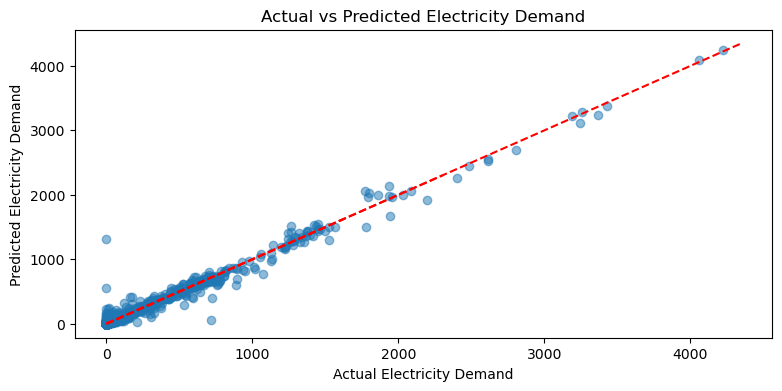

In [20]:
# Create a figure for the scatter plot with specified dimensions
plt.figure(figsize=(9, 4))

# Scatter plot showing actual vs predicted electricity demand with some transparency
plt.scatter(y_test, y_pred_rf, alpha=0.5)

# Plot a reference line for perfect predictions (y = x) using a dashed red line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')

# Label for the x-axis representing actual electricity demand
plt.xlabel('Actual Electricity Demand')

# Label for the y-axis representing predicted electricity demand
plt.ylabel('Predicted Electricity Demand')

# Title for the plot to indicate the content being visualized
plt.title('Actual vs Predicted Electricity Demand')

# Display the plot
plt.show()


 - > **Outcome**:   Points close to the red dashed reference line indicate accurate predictions, while points that deviate significantly from this line suggest that the model is misestimating demand. A tight clustering of points around the line would indicate high model accuracy, whereas a spread of points indicates potential areas for model improvement.


### Predictions vs Actual Values for Energy Consumption


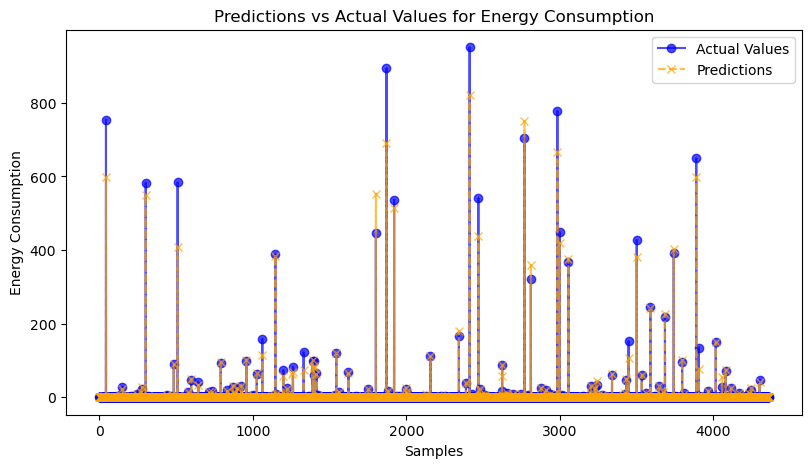

In [21]:
# Set the index for the output variable to be visualized
output_index = 0

# Create a figure for the line plot with specified dimensions
plt.figure(figsize=(9.5, 5))

# Plot actual values using blue circles, with some transparency
plt.plot(y_test.values[:, output_index], label='Actual Values', marker='o', color='blue', linestyle='-', alpha=0.7)

# Plot predicted values using orange crosses, with a dashed line style
plt.plot(y_pred_rf[:, output_index], label='Predictions', marker='x', color='orange', linestyle='--', alpha=0.7)

# Title for the plot indicating the context of energy consumption predictions vs actual values
plt.title('Predictions vs Actual Values for Energy Consumption')

# Label for the x-axis representing the sample indices
plt.xlabel('Samples')

# Label for the y-axis representing energy consumption values
plt.ylabel('Energy Consumption')

# Add a legend to differentiate between actual values and predictions
plt.legend()

# Display the plot
plt.show()


   - > **Outcome**: An ideal line plot would show the predicted values closely following the actual values over all samples. Deviations from this trend can highlight specific instances where the model may have underperformed, helping to identify systematic errors or trends in the model’s predictions.


### Residuals vs Predicted Values

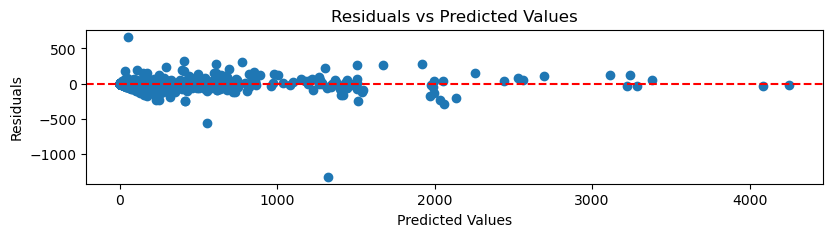

In [22]:
# Calculate the residuals by subtracting predicted values from actual values
residuals = y_test - y_pred_rf

# Create a figure for the residual plot with specified dimensions
plt.figure(figsize=(9.5, 2))

# Scatter plot showing the residuals against the predicted values
plt.scatter(y_pred_rf, residuals)

# Add a horizontal line at y=0 to indicate no error (perfect prediction)
plt.axhline(0, color='red', linestyle='--')

# Title for the plot indicating the comparison of residuals and predicted values
plt.title('Residuals vs Predicted Values')

# Label for the x-axis representing predicted values
plt.xlabel('Predicted Values')

# Label for the y-axis representing residuals (errors)
plt.ylabel('Residuals')

# Display the plot
plt.show()


   - > **Outcome**: If residuals are randomly scattered around zero, it suggests that the model has captured the data well. However, if patterns (e.g., a funnel shape or systematic bias) are observed, this indicates potential issues in the model, such as underfitting or overfitting, or that certain ranges of predicted values are being consistently misestimated.


### Learning Curve Visualization

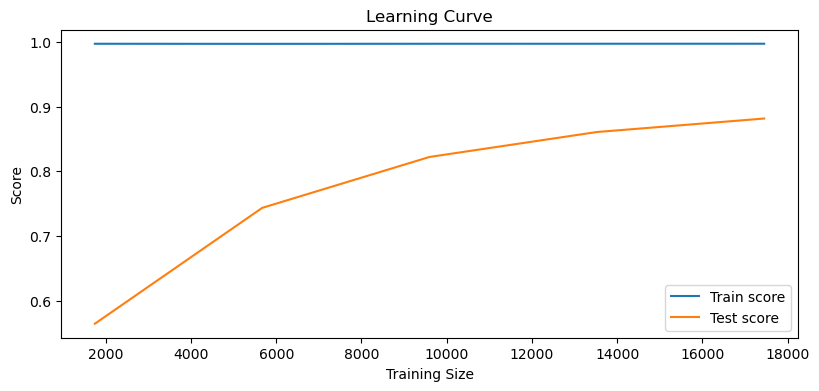

In [23]:
# Compute learning curves by training the model with different sizes of training data
train_sizes, train_scores, test_scores = learning_curve(best_rf_model, X, y, cv=5)

# Calculate the mean training scores across all cross-validation folds
train_mean = train_scores.mean(axis=1)

# Calculate the mean testing scores across all cross-validation folds
test_mean = test_scores.mean(axis=1)

# Create a figure for the learning curve with specified dimensions
plt.figure(figsize=(9.5, 4))

# Plot the mean training scores against the training sizes
plt.plot(train_sizes, train_mean, label='Train score')

# Plot the mean test scores against the training sizes
plt.plot(train_sizes, test_mean, label='Test score')

# Title for the plot indicating it represents a learning curve
plt.title('Learning Curve')

# Label for the x-axis representing the sizes of the training set
plt.xlabel('Training Size')

# Label for the y-axis representing the performance score of the model
plt.ylabel('Score')

# Add a legend to differentiate between training and testing scores
plt.legend()

# Display the plot
plt.show()


   - > **Outcome**: Ideally, both the training and testing scores would converge towards a high accuracy as training size increases. If the training score is high while the test score remains low, it indicates overfitting. Conversely, if both scores are low, this suggests underfitting. This information is invaluable for tuning model parameters and deciding whether more data is needed.

### Contrast Predictions with Actual Values in General

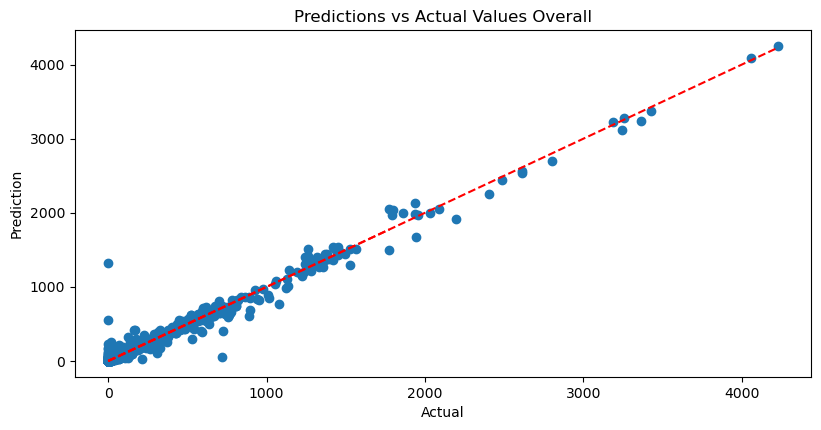

In [24]:
# Create a figure for the scatter plot with specified dimensions
plt.figure(figsize=(9.5, 4.5))

# Scatter plot showing the relationship between actual values and predicted values
plt.scatter(y_test, y_pred_rf)

# Plot a reference line for perfect predictions (y = x) using a dashed red line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')

# Label for the x-axis representing actual values
plt.xlabel('Actual')

# Label for the y-axis representing predicted values
plt.ylabel('Prediction')

# Title for the plot indicating the overall comparison of predictions vs actual values
plt.title('Predictions vs Actual Values Overall')

# Display the plot
plt.show()


   - > **Outcome**: A good performance would show points clustered around the reference line, indicating that the model is consistently predicting well across all samples. Any significant spread indicates variability in prediction accuracy, which may require further investigation into specific data segments or features.

---

## 10. Conclusion

In this project, both the **Random Forest** and **Neural Network** models demonstrated their effectiveness in predicting renewable energy generation. 

> ### Performance Overview
- The **Random Forest model** showcased notable strengths, particularly in its training speed and prediction accuracy. Its ability to handle high-dimensional data and capture complex interactions among features contributed to low error rates, making it a reliable choice for this type of analysis.
- On the other hand, the **Neural Network model**, despite being slightly slower in training, also yielded satisfactory results. Neural networks are known for their capacity to model intricate relationships in data, and this project highlighted their potential in the realm of energy predictions. There remains room for further optimization in future iterations, particularly in tuning hyperparameters and experimenting with different architectures.

> ### Future Directions
Looking ahead, my goal is to push the boundaries of this work by implementing an advanced **Artificial Intelligence** system that can handle larger datasets using **Deep Learning** techniques. This AI would not only provide predictions but also enable interactive communication, allowing users to discuss energy-related challenges and propose actionable solutions for achieving a more sustainable future.

To enhance this AI's capabilities, I plan to integrate **APIs** that deliver real-time data feeds, enabling the system to continuously update and refine its understanding of energy dynamics. By leveraging these data streams, the AI could analyze trends, identify inefficiencies, and suggest improvements, ultimately contributing to the development of smarter energy management solutions.

In conclusion, while the current models performed admirably, this vision of a conversational, data-driven AI specialized in energy solutions presents an exciting avenue for future exploration.



## 11. Acknowledgements

I would like to express my heartfelt gratitude to **Ironhack Bootcamp** for all the invaluable knowledge and skills I've acquired throughout this journey. The experience has not only been educational but also incredibly enriching on a personal level. 

A special thanks to my amazing mentors, **Santiago, Antonio,** and **Nicolás**, whose guidance and support have been instrumental in my learning process. Your insights and encouragement have motivated me to push my limits and strive for excellence.

I also want to extend my appreciation to all my fellow classmates. Thank you for the countless moments of laughter, collaboration, and hard work we shared together. These memories will stay with me as a testament to our collective journey. 

*Thank you all for being a part of this transformative experience!*


*Carlos Vergara Gámez*

---